In [98]:
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.ar_model import AutoReg
from random import random
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [63]:
date_time_format = '%Y/%m/%d %H:%M:%S'

def preprocess(filename, delimiter = ';'):
    data = pd.read_csv(filename, sep = delimiter)
    
    data['EVENT_PURPOSE'] = data['EVENT_C'] + '_' + data['DERIVED_CNTR_PURP_C']
    
    # data["BTR1_DATE"] = [dt.strptime(x, date_time_format).date() for x in data.BTR1]
    data["ATD1_DATE"] = [dt.strptime(x, date_time_format).date() for x in data.ATD1]
    # data["ATU1_DATE"] = [dt.strptime(x, date_time_format).date() for x in data.ATU1]
    # data["BTR2_DATE"] = [dt.strptime(x, date_time_format).date() for x in data.BTR2]
    data["ATD2_DATE"] = [dt.strptime(x, date_time_format).date() for x in data.ATD2]
    # data["ATU2_DATE"] = [dt.strptime(x, date_time_format).date() for x in data.ATU2]
    
    data['DIFF_ATD1_BTR1'] = [(dt.strptime(row['ATD1'], date_time_format) - dt.strptime(row['BTR1'], date_time_format)).total_seconds() / 60 \
                          for index, row in data.iterrows()]
    data['DIFF_ATU1_ATD1'] = [(dt.strptime(row['ATU1'], date_time_format) - dt.strptime(row['ATD1'], date_time_format)).total_seconds() / 60 \
                              for index, row in data.iterrows()]
    data['DIFF_ATD2_BTR2'] = [(dt.strptime(row['ATD2'], date_time_format) - dt.strptime(row['BTR2'], date_time_format)).total_seconds() / 60 \
                              for index, row in data.iterrows() if not pd.isna(row['BTR2']) and not pd.isna(row['ATD2'])]
    data['DIFF_ATU2_ATD2'] = [(dt.strptime(row['ATU2'], date_time_format) - dt.strptime(row['ATD2'], date_time_format)).total_seconds() / 60 \
                              for index, row in data.iterrows() if not pd.isna(row['ATU2']) and not pd.isna(row['ATD2'])]
    
    data['DIFF_ATU2_ATD1'] = [(dt.strptime(row['ATU2'], date_time_format) - dt.strptime(row['ATD1'], date_time_format)).total_seconds() / 60 \
                          for index, row in data.iterrows() if not pd.isna(row['ATU2'])]
    
    data = data.drop(columns = ['EVENT_C', 'ABBR_VESSEL_M1', 'BTR1', 'ATD1', 'ATU1', 'SERVICE_TYPE_DESC_X1', \
                            'CONSORTIUM_C1', 'ABBR_VESSEL_M2', 'BTR2', 'ATD2', 'ATU2', 'SERVICE_TYPE_DESC_X2', \
                            'CONSORTIUM_C2', 'OPR_GROUP_C', 'SUMOFBOX_Q'])
    return data

In [3]:
data = preprocess("../data/connection_2017.csv")

In [64]:
data.head()

,CNTR_STATUS_C,DISC_PORT1_C,LOAD_PORT_C,LINE_C1_GROUP,SERVICE_C1,DIRECTION_C1,CAPACITY1,LINE_C2_GROUP,SERVICE_C2,DIRECTION_C2,...,DERIVED_CNTR_PURP_C,SUMOFTEU_Q,EVENT_PURPOSE,ATD1_DATE,ATD2_DATE,DIFF_ATD1_BTR1,DIFF_ATU1_ATD1,DIFF_ATD2_BTR2,DIFF_ATU2_ATD2,DIFF_ATU2_ATD1
0,F,NLRTM,VNPHG,L389,S7569,E,1118,L391,S7434,W,...,TSHIP,2.0,DISC_TSHIP,2017-03-22,2017-04-03,35.0,702.0,380.0,1572.0,18319.0
1,F,INKAT,CNNGB,L381,S7389,W,5060,L341,S7340,W,...,TSHIP,18.0,LOAD_TSHIP,2017-05-13,2017-05-09,45.0,1674.0,100.0,1304.0,-3747.0
2,F,HRRJK,MYTPP,L349,S7388,E,2702,L344,S7634,W,...,TSHIP,2.0,DISC_TSHIP,2017-09-24,2017-10-03,20.0,620.0,65.0,700.0,13213.0
3,F,CAVA3,IDBLW,L376,S7439,W,1441,L391,S7462,E,...,TSHIP,9.0,DISC_TSHIP,2017-05-21,2017-05-23,23.0,890.0,265.0,1377.0,5286.0
4,F,SAJED,VNSGN,L352,S7639,W,10020,L341,S7349,W,...,TSHIP,4.0,LOAD_TSHIP,2017-05-28,2017-05-25,1297.0,1100.0,25.0,185.0,-3431.0


In [65]:
data['ATD1_DATE'] = pd.to_datetime(data['ATD1_DATE'])
data['ATD2_DATE'] = pd.to_datetime(data['ATD2_DATE'])

In [66]:
print ("Categorical Variables")
print(data['CNTR_STATUS_C'].nunique(), ":CNTR_STATUS_C")
print(data['DISC_PORT1_C'].nunique(), ":DISC_PORT1_C")
print(data['LOAD_PORT_C'].nunique(), ":LOAD_PORT_C")
print(data['LINE_C1_GROUP'].nunique(), ":LINE_C1_GROUP")
print(data['LINE_C2_GROUP'].nunique(), ":LINE_C2_GROUP")
print(data['SERVICE_C1'].nunique(), ":SERVICE_C1")
print(data['SERVICE_C2'].nunique(), ":SERVICE_C2")

Categorical Variables
2 :CNTR_STATUS_C
452 :DISC_PORT1_C
636 :LOAD_PORT_C
57 :LINE_C1_GROUP
58 :LINE_C2_GROUP
318 :SERVICE_C1
327 :SERVICE_C2


In [67]:
df = data[data['EVENT_PURPOSE'] == 'LOAD_TSHIP']
df = df.sort_values(by = 'ATD1_DATE')

drop_columns = ['DERIVED_CNTR_PURP_C', 'EVENT_PURPOSE', 'DISC_PORT1_C', 'LOAD_PORT_C',\
               'LINE_C1_GROUP', 'LINE_C2_GROUP', 'SERVICE_C1', 'SERVICE_C2']

df_new = df.drop(drop_columns, axis=1)

In [68]:
def one_hot_encoding(df, categorical_features):
    for category in categorical_features:
        if "weekday" in category:
            prefix = 'is_day'
        elif "month" in category:
            prefix = 'is_month'
        elif "DIRECTION_C1" in category:
            prefix = 'is_C1_direction'
        elif "DIRECTION_C2" in category:
            prefix = 'is_C2_direction'
        else: 
            prefix = 'is'
        dummies = pd.get_dummies(df['{}'.format(category)], prefix=prefix, dummy_na=False)
        df = pd.concat([df, dummies], axis=1)
    return df

def temporal_features(df):
    df['ATD1_month'] = df['ATD1_DATE'].dt.month
    df['ATD1_weekday'] = df['ATD1_DATE'].dt.weekday
    df['ATD2_month'] = df['ATD2_DATE'].dt.month
    df['ATD2_weekday'] = df['ATD2_DATE'].dt.weekday
    return df

In [71]:
categorical_features = ['CNTR_STATUS_C', 'DIRECTION_C1', 'DIRECTION_C2',\
                        'ATD1_weekday','ATD2_weekday', 'ATD1_month', 'ATD2_month']

In [72]:
df_new = temporal_features(df_new)
df_new = one_hot_encoding(df_new, categorical_features)


In [74]:
df_new = df_new.drop(categorical_features + ['ATD2_DATE'], axis = 1)

In [85]:
df_new.fillna(0, inplace = True)

In [83]:
df_indexed = df_new.set_index('ATD1_DATE')

In [84]:

df_new.isna().sum()

CAPACITY1               0
CAPACITY2            5214
SUMOFTEU_Q              0
ATD1_DATE               0
DIFF_ATD1_BTR1          0
DIFF_ATU1_ATD1          0
DIFF_ATD2_BTR2          0
DIFF_ATU2_ATD2          0
DIFF_ATU2_ATD1          0
is_E                    0
is_F                    0
is_C1_direction_E       0
is_C1_direction_N       0
is_C1_direction_S       0
is_C1_direction_W       0
is_C1_direction_X       0
is_C2_direction_E       0
is_C2_direction_N       0
is_C2_direction_S       0
is_C2_direction_W       0
is_C2_direction_X       0
is_day_0                0
is_day_1                0
is_day_2                0
is_day_3                0
is_day_4                0
is_day_5                0
is_day_6                0
is_day_0                0
is_day_1                0
is_day_2                0
is_day_3                0
is_day_4                0
is_day_5                0
is_day_6                0
is_month_1              0
is_month_2              0
is_month_3              0
is_month_4  

In [103]:
df_model = df_indexed['SUMOFTEU_Q']

In [104]:
df_model = df_model.resample('D').sum()

In [123]:
model = Prophet()

In [124]:
split_date = '01-Dec-2017'
train = df_model.loc[df_model.index <= split_date].copy()
test = df_model.loc[df_model.index > split_date].copy()

In [125]:
model.fit(train.reset_index().rename(columns={'ATD1_DATE':'ds',
                                              'SUMOFTEU_Q':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [112]:
test_fcst = model.predict(df=test.reset_index().rename(columns={'ATD1_DATE':'ds'}))

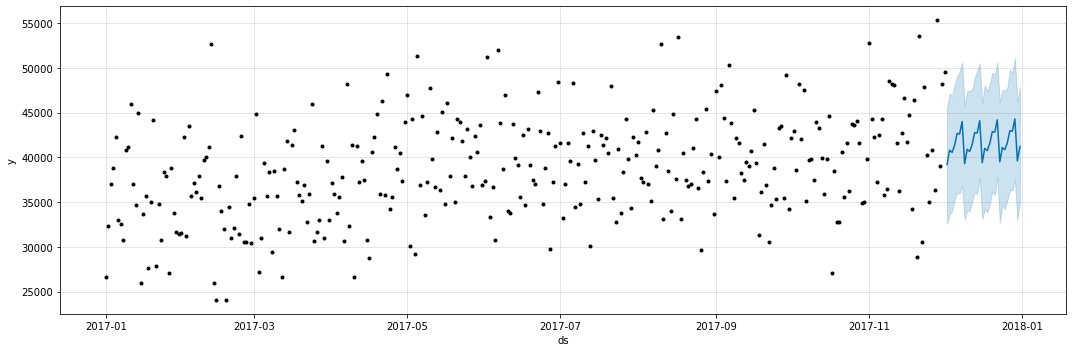

In [113]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(test_fcst,
                 ax=ax)
plt.show()

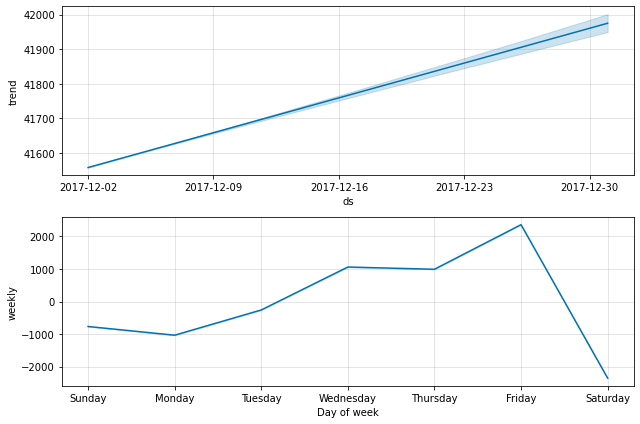

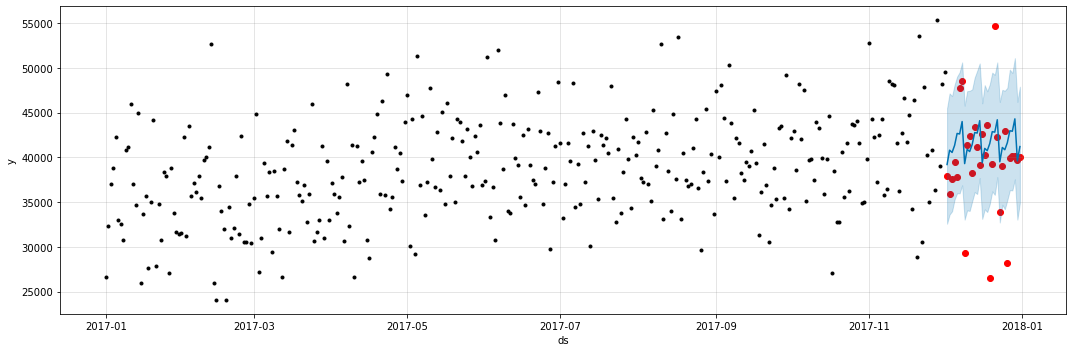

In [114]:
# Plot the components of the model
fig = model.plot_components(test_fcst)

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test, color='r')
fig = model.plot(test_fcst, ax=ax)

In [115]:
mean_squared_error(y_true=test,
                   y_pred=test_fcst['yhat'])

30251010.419814434